In [ ]:
# laplace-CAN-paper-figures.ipynb
#
# Bryan Daniels
# 2024/2/7

Simulating a continuous attractor network (CAN) that matches with the Laplace
transform picture of Howard et al. 2018.  We have:

   - Units connected in a 1-D topology with marginally stable activity patterns
     that consist of an "edge" at any location along the line
   - The edge moves with speed that scales as $1/t$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize

from laplace_network import asymmetric_laplace_network,gaussian_laplace_network,find_edge_location
import laplace_CAN_figures as lf

from importlib import reload
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

# Demonstrate exponential decay using asymmetric interaction kernel

In [2]:
from laplace_network import asymmetric_edge_states

In [3]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

sim_type = 'future' #'past' # 'future'
Npopulation = 100 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z 
delta_z = 1/4 #1/8 #1/4  
n_0_asymmetric = Npopulation/2 
if sim_type == 'past':
    t_0_asymmetric = 10 
elif sim_type == 'future':
    t_0_asymmetric = -80

# 2024/3/1 set sigma large compared to range of states for all synapses except edge->edge
sigma_edge = 0.5 #0.25 #0.5 
sigma_other = 20 

# scale of interaction strength between neighbors
J = 2 #2 #4
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = sigma_other/2
# strength of feedback from bump to edge neurons varies with n 
J_bump_edge_abs_max = 1 # 10 # to avoid instability
J_bump_edge_scale_factor_asymmetric = sigma_other
J_bump_edge = [ -J_bump_edge_scale_factor_asymmetric*np.clip(
                    1./t_0_asymmetric*1./delta_z*np.exp(-delta_z*(n-n_0_asymmetric)),
                    -J_bump_edge_abs_max,+J_bump_edge_abs_max) for n in range(Npopulation) ] 

net_asymmetric = asymmetric_laplace_network(
                      Npopulation=Npopulation,
                      J=J,
                      delta_z=delta_z,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      sigma_edge=sigma_edge,
                      sigma_other=sigma_other)

zero_velocity_asymmetric_edge_Jmat: edge_shift = 0.1256244214584455


In [8]:
# run simulation

noise_var = 1e-6 #1e-2 #0. # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) 
t_final = t_0_asymmetric + 2**(i_final-1)
delta_t = 0.01 #0.001 
seed = 12345

# start with edge state at location n_0 at time t_0
edge_t = t_0_asymmetric 
initial_guess_edge = net_asymmetric.J*(2*asymmetric_edge_states(np.arange(0,Npopulation),
                                                                edge_t,
                                                                delta_z=delta_z,
                                                                n_0=n_0_asymmetric,
                                                                t_0=t_0_asymmetric)-1)
edge_state = net_asymmetric.find_edge_state(n_0_asymmetric,
                                 initial_guess_edge=initial_guess_edge,
                                 method='translate')

# simulate dynamics
states_asymmetric = net_asymmetric.simulate_dynamics(edge_state,
                               t_final-t_0_asymmetric,
                               noise_var,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_asymmetric.index = states_asymmetric.index + t_0_asymmetric

Text(0, 0.5, 'Neural state')

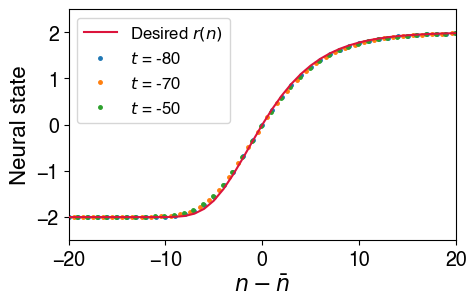

In [10]:
# compare simulated shape of edge to desired shape

plt.figure(figsize=(5,3))

nList = np.arange(0,net_asymmetric.Npopulation)
desired_edge_shape = net_asymmetric.J*(2*asymmetric_edge_states(nList,t_0_asymmetric,
                                                                delta_z=delta_z,
                                                                n_0=n_0_asymmetric,
                                                                t_0=t_0_asymmetric)-1)
desired_edge_offset = find_edge_location(desired_edge_shape,Npopulation)[0]
plt.plot(nList-desired_edge_offset,desired_edge_shape,
         label='Desired $r(n)$',
         color='crimson',
         zorder=+10)

for t in [t_0_asymmetric,
          t_0_asymmetric + 10, #t_0_asymmetric*2,
          t_0_asymmetric + 30, #t_0_asymmetric*4,
         ]:
    edge_offset = np.sort(find_edge_location(states_asymmetric.loc[t],Npopulation))[0]
    plt.plot(nList - edge_offset,
             states_asymmetric.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
                 '.',label="$t$ = {}".format(int(t)),lw=1,ms=5)
plt.axis(xmin=-5/net_asymmetric.delta_z,
         xmax=5/net_asymmetric.delta_z,
         ymin=-net_asymmetric.J-0.5,
         ymax=net_asymmetric.J+0.5)
plt.legend()
plt.xlabel('$n - \\bar n$')
plt.ylabel('Neural state')

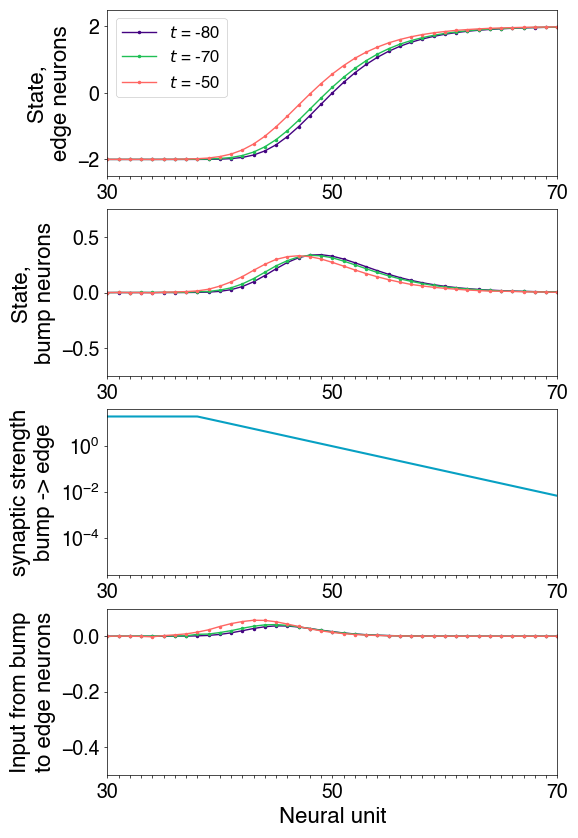

In [12]:
lf.translation_simulation_plot(net_asymmetric,states_asymmetric,states_asymmetric,
                               num_neurons_scale=5/net_asymmetric.delta_z,
                               bump_state_min=-0.75,bump_state_max=0.75)
filename = '240425_asymmetric_translation_simulation_{}'.format(sim_type)
if noise_var > 1e-6:
    filename += '_noise'
plt.savefig(filename+'.pdf')

In [29]:
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

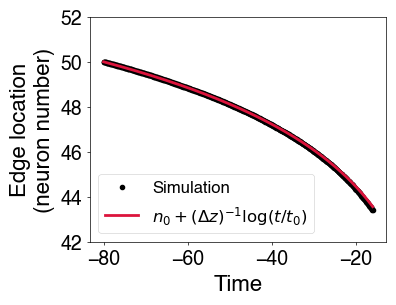

In [30]:
lf.edge_location_plot(net_asymmetric,states_asymmetric,n_0_asymmetric,t_0_asymmetric,delta_z)
plt.xticks(t_0_asymmetric + np.array([10,20,30,40,60]),t_0_asymmetric + np.array([10,20,30,40,60]));
if sim_type == 'past':
    plt.yticks(n_0_asymmetric+np.arange(-2,10,2))
elif sim_type == 'future':
    plt.yticks(n_0_asymmetric-np.arange(-2,10,2))
    plt.xscale('linear')
filename = '240425_asymmetric_edge_location_{}'.format(sim_type)
if noise_var > 1e-6:
    filename += '_noise'
plt.savefig(filename+'.pdf')

In [25]:
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

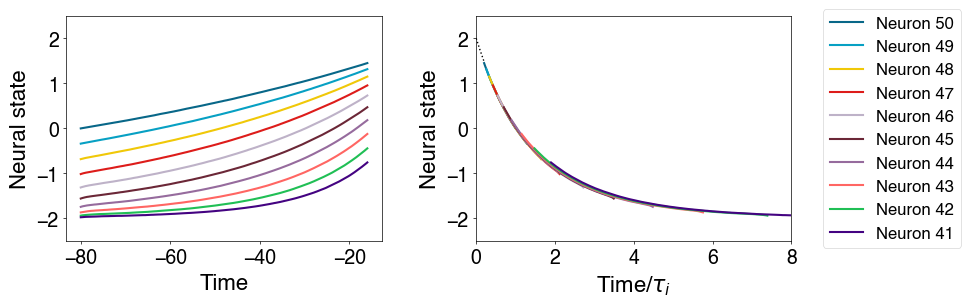

In [26]:
lf.time_rescaling_plot(states_asymmetric,n_0_asymmetric,t_0_asymmetric,delta_z,
                       state_min=-net_asymmetric.J-0.5,state_max=net_asymmetric.J+0.5,
                       delta_n=int(1/delta_z/4),sim_type=sim_type)

# also plot analytical result as dotted line
t_max = max(states_asymmetric.index)
analytical_times = np.linspace(0,t_max,1000)
plt.plot(analytical_times/t_0_asymmetric,
         net_asymmetric.J*(2*asymmetric_edge_states(n_0_asymmetric,analytical_times,
                                                 delta_z=delta_z,n_0=n_0_asymmetric,t_0=t_0_asymmetric)-1),
         'k:',
         zorder=-10,
         lw=1,)
filename = '240425_asymmetric_time_rescaling_{}'.format(sim_type)
if noise_var > 1e-6:
    filename += '_noise'
plt.savefig(filename+'.pdf')

In [41]:
states_asymmetric

,Neuron 0,Neuron 1,Neuron 2,Neuron 3,Neuron 4,Neuron 5,Neuron 6,Neuron 7,Neuron 8,Neuron 9,...,Neuron 190,Neuron 191,Neuron 192,Neuron 193,Neuron 194,Neuron 195,Neuron 196,Neuron 197,Neuron 198,Neuron 199
Time,,,,,,,,,,,,,,,,,,,,,
-80.00,-101.999694,-101.999575,-101.999451,-101.999330,-101.999217,-1.999117,-1.999030,-1.998957,-1.998896,-1.998846,...,0.000119,0.000127,0.000126,0.000117,9.003024,9.002969,9.597189e-09,7.330100e-09,5.593856e-09,0.000000
-79.99,-101.999715,-101.999527,-101.999503,-101.999385,-101.914616,-1.914573,-1.999020,-1.998928,-1.998819,-1.998722,...,0.000045,0.000054,0.000210,0.000143,9.003096,9.003060,-1.020807e-04,-1.413343e-04,1.296664e-04,0.000025
-79.98,-101.999603,-101.999584,-101.999471,-101.999443,-101.831174,-1.831095,-1.999283,-1.998942,-1.998894,-1.998734,...,0.000057,0.000448,0.000184,0.000228,9.003058,9.003072,-1.708213e-04,-6.355877e-06,1.132660e-04,0.000069
-79.97,-101.999508,-101.999531,-101.999434,-101.999442,-101.748304,-1.748313,-1.999234,-1.998922,-1.998960,-1.998790,...,0.000210,0.000473,0.000115,0.000133,9.003096,9.003059,-1.292925e-04,7.871508e-06,8.571924e-05,0.000023
-79.96,-101.999432,-101.999583,-101.999492,-101.999349,-101.666492,-1.666230,-1.999225,-1.998949,-1.999136,-1.998691,...,0.000211,0.000402,0.000145,0.000281,9.003064,9.002958,-1.090104e-04,-1.606102e-04,3.902411e-05,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-16.04,-101.575454,-101.504541,-101.468917,-101.467093,-90.178651,5.814597,-4.645898,-0.494570,-2.254294,-1.592565,...,-0.000122,0.000936,-0.001089,-0.000681,9.003597,9.003332,4.086574e-04,2.628507e-05,3.580615e-04,0.001371
-16.03,-101.575484,-101.504537,-101.468964,-101.467107,-90.178646,5.814598,-4.645889,-0.494412,-2.254286,-1.592556,...,-0.000085,0.001001,-0.000996,-0.000547,9.003505,9.003289,4.411857e-04,4.926451e-05,2.481648e-04,0.001458
-16.02,-101.575454,-101.504700,-101.469011,-101.467223,-90.178524,5.814528,-4.645902,-0.494442,-2.254338,-1.592397,...,-0.000237,0.001032,-0.000972,-0.000684,9.003420,9.003383,5.176324e-04,1.708914e-05,3.727886e-05,0.001509


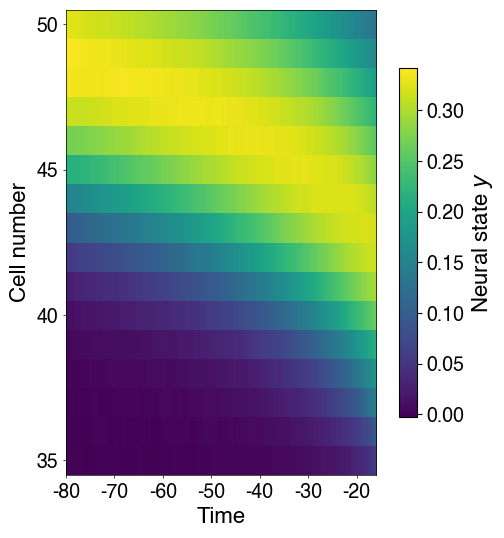

In [64]:
# 2024/1/18 make 2D heat-map plot for "edge" and "bump" neurons
neuronType = 'bump' #'edge' #'bump'
fig = plt.figure(figsize=(6,6))
if sim_type == 'past':
    neuronMin,neuronMax = 50,50+16
elif sim_type == 'future':
    neuronMin,neuronMax = 50-16+1,50+1
if neuronType == 'edge': # "edge" neurons
    plt.matshow(states_asymmetric.T[neuronMin:neuronMax+1],fignum=fig)
    stateName = '$x$'
elif neuronType == 'bump': # "bump" neurons
    plt.matshow(states_asymmetric.T[Npopulation+neuronMin:Npopulation+neuronMax+1],fignum=fig)
    stateName = '$y$'
else:
    raise Exception("unrecognized neuronType")
plt.gca().set_aspect(600)
plt.gca().xaxis.tick_bottom()

if sim_type == 'past':
    plt.xticks(range(0,7000,1000),range(t_0_asymmetric,t_0_asymmetric+70,10))
    plt.yticks(range(0,neuronMax-neuronMin,5),range(neuronMin,neuronMax,5))
elif sim_type == 'future':
    plt.xticks(range(0,7000,1000),range(t_0_asymmetric,t_0_asymmetric+70,10))
    plt.yticks(range(0,neuronMax-neuronMin,5),range(neuronMin,neuronMax,5))
    #plt.yticks(range(neuronMax-neuronMin,0,-5),range(neuronMax,neuronMin,-5))
    #plt.axis(xmin=7000,xmax=0)
    plt.axis(ymin=neuronMax-neuronMin,ymax=0)
    plt.axis(ymin=-0.5,ymax=neuronMax-neuronMin-0.5)
plt.xlabel('Time')
plt.ylabel('Cell number')
plt.colorbar(shrink=0.75,label='Neural state {}'.format(stateName))
#plt.axis(ymin=70,ymax=40)
#fig.subplots_adjust(bottom=0.9,top=0.95) # doesn't do anything?
lf.defaultFigure.makePretty()
filename = '240425_{}_neuron_firing_rate_vs_cell_and_time_{}'.format(neuronType,sim_type)
if noise_var > 1e-6:
    filename += '_noise'
plt.savefig(filename+'.pdf')

# Demonstrate geometric series of timescales using symmetric kernel

In [23]:
def states2rates(states):
    return 0.5*(1.+np.tanh(states))

In [24]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation_symmetric = 100 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z 
delta_z = 1/4 
# scale of interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n
t_0_symmetric = 10
n_0_symmetric = Npopulation_symmetric/2 
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor_symmetric = 1 
J_bump_edge = [ -J_bump_edge_scale_factor_symmetric*min(1./t_0_symmetric*1./delta_z*np.exp(-delta_z*(n-n_0_symmetric)),
                                              J_bump_edge_max) for n in range(Npopulation_symmetric) ]
kernel_width = 2 
sigma = 1. 

net_symmetric = gaussian_laplace_network(
                      Npopulation=Npopulation_symmetric,
                      J=J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      kernel_width=kernel_width,
                      sigma=sigma)

In [25]:
# run simulation

noise_var = 1e-6 #1e-4 # strength of noise (variance added per unit time)
i_final = 7 #6 #(t increases exponentially with i) 
t_final = t_0_symmetric + 2**(i_final-1)
delta_t = 0.01 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_state = net_symmetric.find_edge_state(n_0_symmetric)
    
# simulate dynamics
states_symmetric = net_symmetric.simulate_dynamics(edge_state,
                               t_final-t_0_symmetric,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_symmetric.index = states_symmetric.index + t_0_symmetric
rates_symmetric = states2rates(states_symmetric)

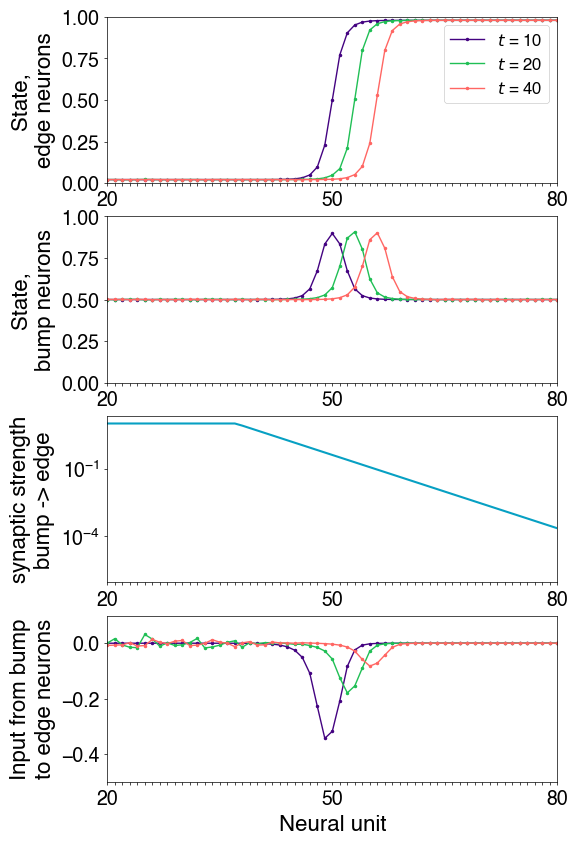

In [49]:
lf.translation_simulation_plot(net_symmetric,rates_symmetric,states_symmetric,
                            state_min=0,state_max=1)
plt.savefig('240214_symmetric_translation_simulation.pdf')

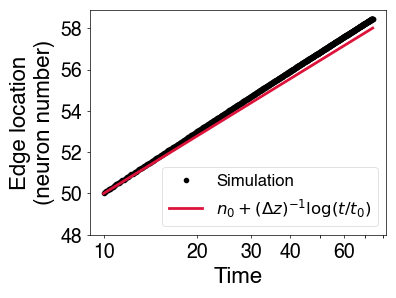

In [60]:
lf.edge_location_plot(net_symmetric,states_symmetric,n_0_symmetric,t_0_symmetric,delta_z)
plt.xticks(t_0_symmetric*np.array([1,2,3,4,6]),t_0_symmetric*np.array([1,2,3,4,6]));
plt.yticks(n_0_symmetric+np.arange(-2,10,2));
plt.savefig('240214_symmetric_edge_location.pdf')

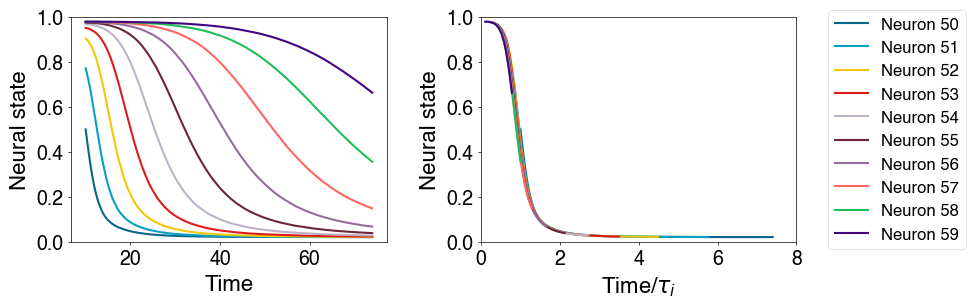

In [53]:
lf.time_rescaling_plot(rates_symmetric,n_0_symmetric,t_0_symmetric,delta_z,
                   state_min=0,state_max=1,
                   delta_n=int(1/delta_z/4))
plt.savefig('240214_symmetric_time_rescaling.pdf')